In [37]:
import pandas as pd
import numpy as np
import random
import os
import warnings
warnings.filterwarnings('ignore')

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
os.environ['PYTHONHASHSEED'] = str(RANDOM_SEED)

X_scaled = pd.read_csv('../data/processed/X_scaled.csv')
y = pd.read_csv('../data/processed/y.csv')['outcome']

mask = ~y.isna()
X_clean = X_scaled[mask]
y_clean = y[mask]

print(f"Loaded data shape: {X_clean.shape}")
print(f"Target shape: {y_clean.shape}")
print(f"\nClass distribution:\n{y_clean.value_counts()}")
print(f"Class imbalance ratio: {y_clean.value_counts()[0] / y_clean.value_counts()[1]:.2f}:1")

Loaded data shape: (1176, 48)
Target shape: (1176,)

Class distribution:
outcome
0.0    1017
1.0     159
Name: count, dtype: int64
Class imbalance ratio: 6.40:1


In [38]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_clean, y_clean, test_size=0.2, random_state=42, stratify=y_clean
)

print(f"Train set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"\nTrain class distribution:\n{pd.Series(y_train).value_counts()}")
print(f"Test class distribution:\n{pd.Series(y_test).value_counts()}")

Train set: (940, 48)
Test set: (236, 48)

Train class distribution:
outcome
0.0    813
1.0    127
Name: count, dtype: int64
Test class distribution:
outcome
0.0    204
1.0     32
Name: count, dtype: int64


#### Hyperparameter Tuning with SMOTE Inside CV

Grid search over LR hyperparameters with SMOTE in pipeline to optimize PR-AUC and track recall.

In [39]:
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import make_scorer, recall_score, average_precision_score

print("-"*70)
print("HYPERPARAMETER TUNING - LOGISTIC REGRESSION WITH SMOTE")
print("-"*70)

# pipeline with SMOTE + LR
pipe = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('clf', LogisticRegression(max_iter=2000, solver='liblinear', random_state=42))
])

# parameter grid
param_grid = {
    'smote__k_neighbors': [3, 5],
    'smote__sampling_strategy': [0.7, 0.85, 1.0],
    'clf__C': [0.01, 0.1, 1, 10],
    'clf__class_weight': [None, 'balanced'],
    'clf__penalty': ['l1', 'l2']
}

# multiple scoring metrics
scorers = {
    'ap': 'average_precision',  # PR-AUC
    'recall': make_scorer(recall_score, pos_label=1),
    'roc_auc': 'roc_auc'
}

# grid search with 5-fold CV
gs = GridSearchCV(
    pipe,
    param_grid,
    scoring=scorers,
    refit='ap',  # optimize for PR-AUC
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    n_jobs=-1,
    verbose=1
)

print("\nStarting grid search")
gs.fit(X_train, y_train)

print("\n" + "-"*70)
print("TUNING RESULTS")
print("-"*70)
print(f"\nBest parameters: {gs.best_params_}")
print(f"Best CV PR-AUC: {gs.best_score_:.4f}")

# get CV results for best model
best_idx = gs.best_index_
print(f"\nBest model CV metrics:")
print(f"  PR-AUC (AP):  {gs.cv_results_['mean_test_ap'][best_idx]:.4f} ± {gs.cv_results_['std_test_ap'][best_idx]:.4f}")
print(f"  Recall:       {gs.cv_results_['mean_test_recall'][best_idx]:.4f} ± {gs.cv_results_['std_test_recall'][best_idx]:.4f}")
print(f"  ROC-AUC:      {gs.cv_results_['mean_test_roc_auc'][best_idx]:.4f} ± {gs.cv_results_['std_test_roc_auc'][best_idx]:.4f}")

best_lr_pipeline = gs.best_estimator_
print("\nBest model saved to 'best_lr_pipeline'")

----------------------------------------------------------------------
HYPERPARAMETER TUNING - LOGISTIC REGRESSION WITH SMOTE
----------------------------------------------------------------------

Starting grid search
Fitting 5 folds for each of 96 candidates, totalling 480 fits

----------------------------------------------------------------------
TUNING RESULTS
----------------------------------------------------------------------

Best parameters: {'clf__C': 0.01, 'clf__class_weight': None, 'clf__penalty': 'l2', 'smote__k_neighbors': 5, 'smote__sampling_strategy': 0.7}
Best CV PR-AUC: 0.5274

Best model CV metrics:
  PR-AUC (AP):  0.5274 ± 0.0568
  Recall:       0.7006 ± 0.0539
  ROC-AUC:      0.8106 ± 0.0294

Best model saved to 'best_lr_pipeline'


In [40]:
# eval best model on test set
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

y_test_array = np.array(y_test)
y_pred = best_lr_pipeline.predict(X_test)
y_prob = best_lr_pipeline.predict_proba(X_test)[:, 1]

print("\n" + "-"*70)
print("TEST SET PERFORMANCE (Default 0.5 Threshold)")
print("-"*70)
print(classification_report(y_test_array, y_pred, target_names=['Survived', 'Died']))

cm = confusion_matrix(y_test_array, y_pred)
print("Confusion Matrix:")
print(f"                Predicted: Survived  Predicted: Died")
print(f"Actual: Survived       {cm[0][0]:6d}            {cm[0][1]:6d}")
print(f"Actual: Died           {cm[1][0]:6d}            {cm[1][1]:6d}")

print(f"\nROC-AUC: {roc_auc_score(y_test_array, y_prob):.4f}")
print(f"PR-AUC:  {average_precision_score(y_test_array, y_prob):.4f}")


----------------------------------------------------------------------
TEST SET PERFORMANCE (Default 0.5 Threshold)
----------------------------------------------------------------------
              precision    recall  f1-score   support

    Survived       0.93      0.83      0.88       204
        Died       0.37      0.62      0.47        32

    accuracy                           0.81       236
   macro avg       0.65      0.73      0.67       236
weighted avg       0.86      0.81      0.82       236

Confusion Matrix:
                Predicted: Survived  Predicted: Died
Actual: Survived          170                34
Actual: Died               12                20

ROC-AUC: 0.8024
PR-AUC:  0.4838


#### Decision Threshold Optimization

Find optimal threshold to maximize F-beta (β=2, prioritizing recall) and meet target recall.

----------------------------------------------------------------------
THRESHOLD OPTIMIZATION
----------------------------------------------------------------------

Best threshold by F2-score: 0.460
  Recall:    0.6875
  Precision: 0.3492
  F2-Score:  0.5759

Threshold for recall ≥ 0.75: 0.100
  Recall:    1.0000
  Precision: 0.1461


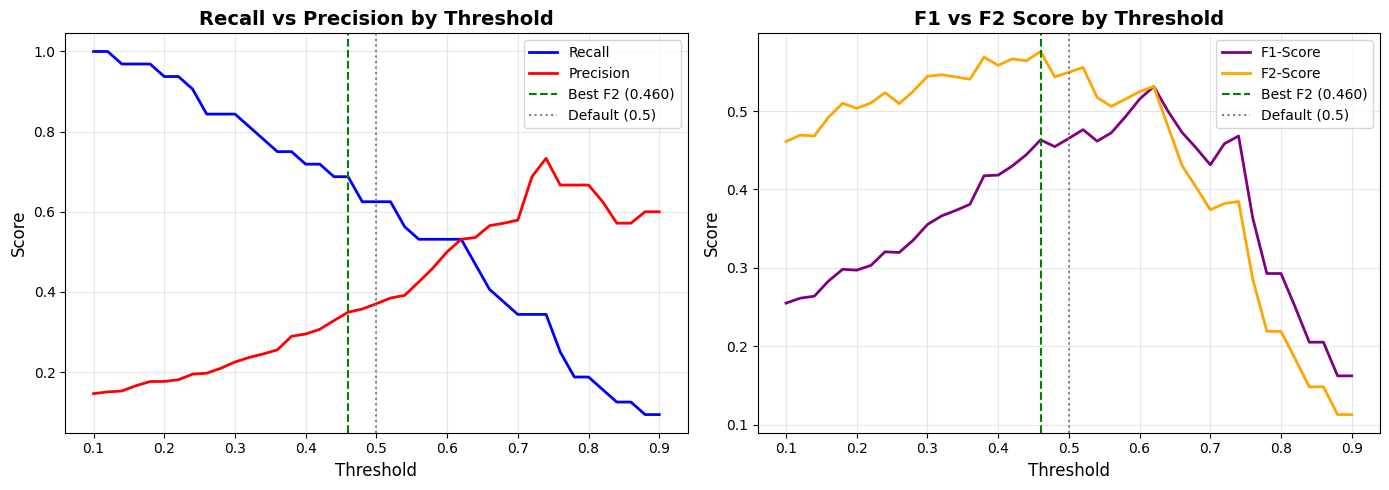


Recommended threshold: 0.460 (maximizes F2)


In [41]:
from sklearn.metrics import precision_score, fbeta_score
import matplotlib.pyplot as plt

print("-"*70)
print("THRESHOLD OPTIMIZATION")
print("-"*70)

# test different thresholds
thresholds = np.linspace(0.1, 0.9, 41)
metrics = []

for threshold in thresholds:
    y_pred_thresh = (y_prob >= threshold).astype(int)
    
    recall = recall_score(y_test_array, y_pred_thresh, pos_label=1)
    precision = precision_score(y_test_array, y_pred_thresh, pos_label=1, zero_division=0)
    f1 = fbeta_score(y_test_array, y_pred_thresh, beta=1, pos_label=1, zero_division=0)
    f2 = fbeta_score(y_test_array, y_pred_thresh, beta=2, pos_label=1, zero_division=0)
    
    metrics.append({
        'threshold': threshold,
        'recall': recall,
        'precision': precision,
        'f1': f1,
        'f2': f2
    })

metrics_df = pd.DataFrame(metrics)

# find best threshold by F2 (prioritizes recall)
best_f2_idx = metrics_df['f2'].idxmax()
best_f2_threshold = metrics_df.loc[best_f2_idx, 'threshold']
best_f2_recall = metrics_df.loc[best_f2_idx, 'recall']
best_f2_precision = metrics_df.loc[best_f2_idx, 'precision']
best_f2_score = metrics_df.loc[best_f2_idx, 'f2']

print(f"\nBest threshold by F2-score: {best_f2_threshold:.3f}")
print(f"  Recall:    {best_f2_recall:.4f}")
print(f"  Precision: {best_f2_precision:.4f}")
print(f"  F2-Score:  {best_f2_score:.4f}")

# find threshold for target recall
target_recall = 0.75
feasible = metrics_df[metrics_df['recall'] >= target_recall]

if len(feasible) > 0:
    best_target_idx = feasible['threshold'].idxmin()
    target_threshold = feasible.loc[best_target_idx, 'threshold']
    target_recall_actual = feasible.loc[best_target_idx, 'recall']
    target_precision = feasible.loc[best_target_idx, 'precision']
    
    print(f"\nThreshold for recall ≥ {target_recall:.2f}: {target_threshold:.3f}")
    print(f"  Recall:    {target_recall_actual:.4f}")
    print(f"  Precision: {target_precision:.4f}")
else:
    print(f"\n⚠ No threshold achieves recall ≥ {target_recall:.2f}")
    target_threshold = best_f2_threshold

# visualize threshold trade-offs
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# plot 1: Recall vs Precision
ax1.plot(metrics_df['threshold'], metrics_df['recall'], 'b-', label='Recall', linewidth=2)
ax1.plot(metrics_df['threshold'], metrics_df['precision'], 'r-', label='Precision', linewidth=2)
ax1.axvline(best_f2_threshold, color='green', linestyle='--', label=f'Best F2 ({best_f2_threshold:.3f})')
ax1.axvline(0.5, color='gray', linestyle=':', label='Default (0.5)')
ax1.set_xlabel('Threshold', fontsize=12)
ax1.set_ylabel('Score', fontsize=12)
ax1.set_title('Recall vs Precision by Threshold', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# plot 2: F-scores
ax2.plot(metrics_df['threshold'], metrics_df['f1'], 'purple', label='F1-Score', linewidth=2)
ax2.plot(metrics_df['threshold'], metrics_df['f2'], 'orange', label='F2-Score', linewidth=2)
ax2.axvline(best_f2_threshold, color='green', linestyle='--', label=f'Best F2 ({best_f2_threshold:.3f})')
ax2.axvline(0.5, color='gray', linestyle=':', label='Default (0.5)')
ax2.set_xlabel('Threshold', fontsize=12)
ax2.set_ylabel('Score', fontsize=12)
ax2.set_title('F1 vs F2 Score by Threshold', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nRecommended threshold: {best_f2_threshold:.3f} (maximizes F2)")
optimal_threshold = best_f2_threshold

In [42]:
# eval with optimal threshold
y_pred_optimal = (y_prob >= optimal_threshold).astype(int)

print("\n" + "-"*70)
print(f"TEST SET PERFORMANCE (Optimal Threshold: {optimal_threshold:.3f})")
print("-"*70)
print(classification_report(y_test_array, y_pred_optimal, target_names=['Survived', 'Died']))

cm_optimal = confusion_matrix(y_test_array, y_pred_optimal)
print("Confusion Matrix:")
print(f"                Predicted: Survived  Predicted: Died")
print(f"Actual: Survived       {cm_optimal[0][0]:6d}            {cm_optimal[0][1]:6d}")
print(f"Actual: Died           {cm_optimal[1][0]:6d}            {cm_optimal[1][1]:6d}")

print(f"\nF2-Score: {fbeta_score(y_test_array, y_pred_optimal, beta=2, pos_label=1):.4f}")


----------------------------------------------------------------------
TEST SET PERFORMANCE (Optimal Threshold: 0.460)
----------------------------------------------------------------------
              precision    recall  f1-score   support

    Survived       0.94      0.80      0.86       204
        Died       0.35      0.69      0.46        32

    accuracy                           0.78       236
   macro avg       0.65      0.74      0.66       236
weighted avg       0.86      0.78      0.81       236

Confusion Matrix:
                Predicted: Survived  Predicted: Died
Actual: Survived          163                41
Actual: Died               10                22

F2-Score: 0.5759


#### Probability Calibration

Calibrate predicted probabilities to align with true death rates for reliable risk stratification.

----------------------------------------------------------------------
PROBABILITY CALIBRATION
----------------------------------------------------------------------

Calibrating probabilities using isotonic regression...


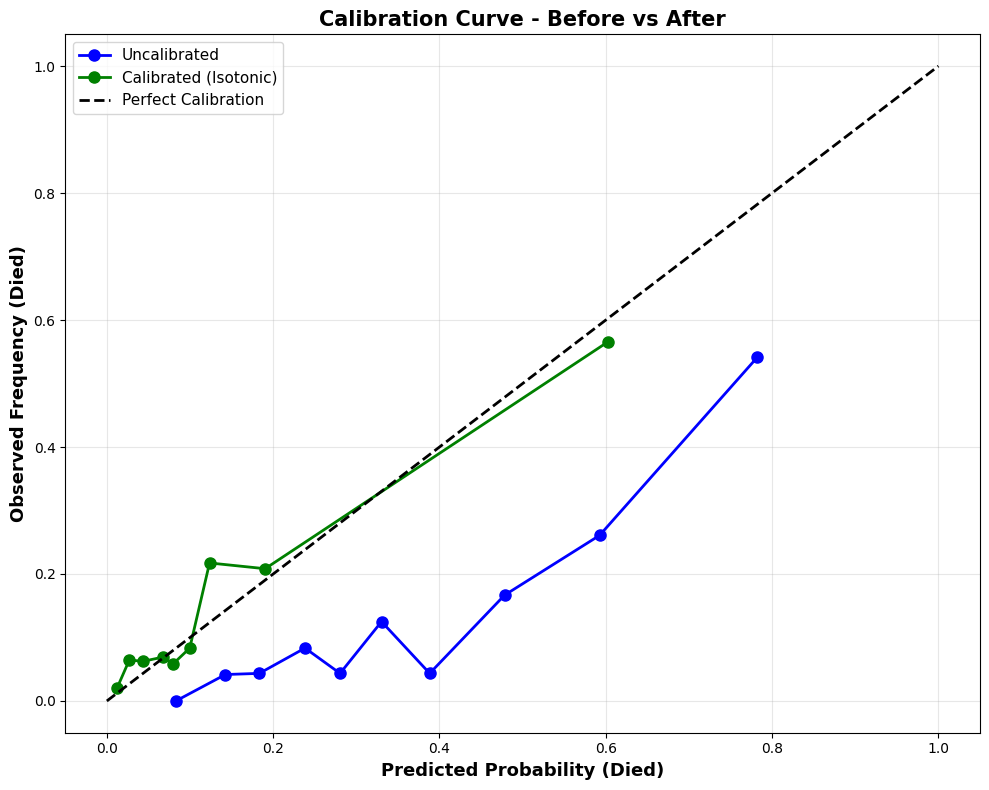


Calibration complete!

Interpretation:
- Points closer to diagonal = better calibrated probabilities
- Calibrated model's probabilities now reflect true death rates
- Use calibrated model for risk stratification (Low/Medium/High)


In [43]:
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

print("-"*70)
print("PROBABILITY CALIBRATION")
print("-"*70)

# calibrate using isotonic regression on training set
print("\nCalibrating probabilities using isotonic regression...")
calibrated_lr = CalibratedClassifierCV(
    estimator=best_lr_pipeline,
    method='isotonic',
    cv=5
)
calibrated_lr.fit(X_train, y_train)

# get calibrated probabilities
y_prob_uncalib = best_lr_pipeline.predict_proba(X_test)[:, 1]
y_prob_calib = calibrated_lr.predict_proba(X_test)[:, 1]

# calibration curves
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

for name, probs, color in [
    ('Uncalibrated', y_prob_uncalib, 'blue'),
    ('Calibrated (Isotonic)', y_prob_calib, 'green')
]:
    frac_pos, mean_pred = calibration_curve(y_test_array, probs, n_bins=10, strategy='quantile')
    ax.plot(mean_pred, frac_pos, marker='o', linewidth=2, markersize=8, 
            label=name, color=color)

# perfect calibration line
ax.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Perfect Calibration')

ax.set_xlabel('Predicted Probability (Died)', fontsize=13, fontweight='bold')
ax.set_ylabel('Observed Frequency (Died)', fontsize=13, fontweight='bold')
ax.set_title('Calibration Curve - Before vs After', fontsize=15, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\nCalibration complete!")
print("\nInterpretation:")
print("- Points closer to diagonal = better calibrated probabilities")
print("- Calibrated model's probabilities now reflect true death rates")
print("- Use calibrated model for risk stratification (Low/Medium/High)")

In [44]:
# calibrated vs uncalibrated performance
y_pred_calib = (y_prob_calib >= optimal_threshold).astype(int)

print("\n" + "-"*70)
print("CALIBRATED MODEL PERFORMANCE")
print("-"*70)
print(classification_report(y_test_array, y_pred_calib, target_names=['Survived', 'Died']))

print(f"\nMetrics comparison:")
print(f"                      Uncalibrated  Calibrated")
print(f"ROC-AUC:              {roc_auc_score(y_test_array, y_prob_uncalib):.4f}        {roc_auc_score(y_test_array, y_prob_calib):.4f}")
print(f"PR-AUC:               {average_precision_score(y_test_array, y_prob_uncalib):.4f}        {average_precision_score(y_test_array, y_prob_calib):.4f}")
print(f"Recall (Died):        {recall_score(y_test_array, y_pred_optimal, pos_label=1):.4f}        {recall_score(y_test_array, y_pred_calib, pos_label=1):.4f}")

final_model = calibrated_lr
print("\nUsing calibrated model as final model")


----------------------------------------------------------------------
CALIBRATED MODEL PERFORMANCE
----------------------------------------------------------------------
              precision    recall  f1-score   support

    Survived       0.90      0.98      0.94       204
        Died       0.69      0.34      0.46        32

    accuracy                           0.89       236
   macro avg       0.80      0.66      0.70       236
weighted avg       0.88      0.89      0.87       236


Metrics comparison:
                      Uncalibrated  Calibrated
ROC-AUC:              0.8024        0.8001
PR-AUC:               0.4838        0.4475
Recall (Died):        0.6875        0.3438

Using calibrated model as final model


#### Feature Importance & Interpretability

Extract and visualize the most important features for clinical interpretation and Streamlit UI.

----------------------------------------------------------------------
FEATURE IMPORTANCE ANALYSIS
----------------------------------------------------------------------

Top 20 Most Important Features:
----------------------------------------------------------------------
Renal failure                        Coef: -0.3253  ↓ Decreases death risk
deficiencyanemias                    Coef: -0.2769  ↓ Decreases death risk
Blood calcium                        Coef: -0.2378  ↓ Decreases death risk
Urea nitrogen                        Coef:  0.2277  ↑ Increases death risk
Bicarbonate                          Coef: -0.2105  ↓ Decreases death risk
Urine output                         Coef: -0.1994  ↓ Decreases death risk
Leucocyte                            Coef:  0.1974  ↑ Increases death risk
Platelets                            Coef: -0.1959  ↓ Decreases death risk
COPD                                 Coef: -0.1944  ↓ Decreases death risk
PCO2                                 Coef:  0.1943 

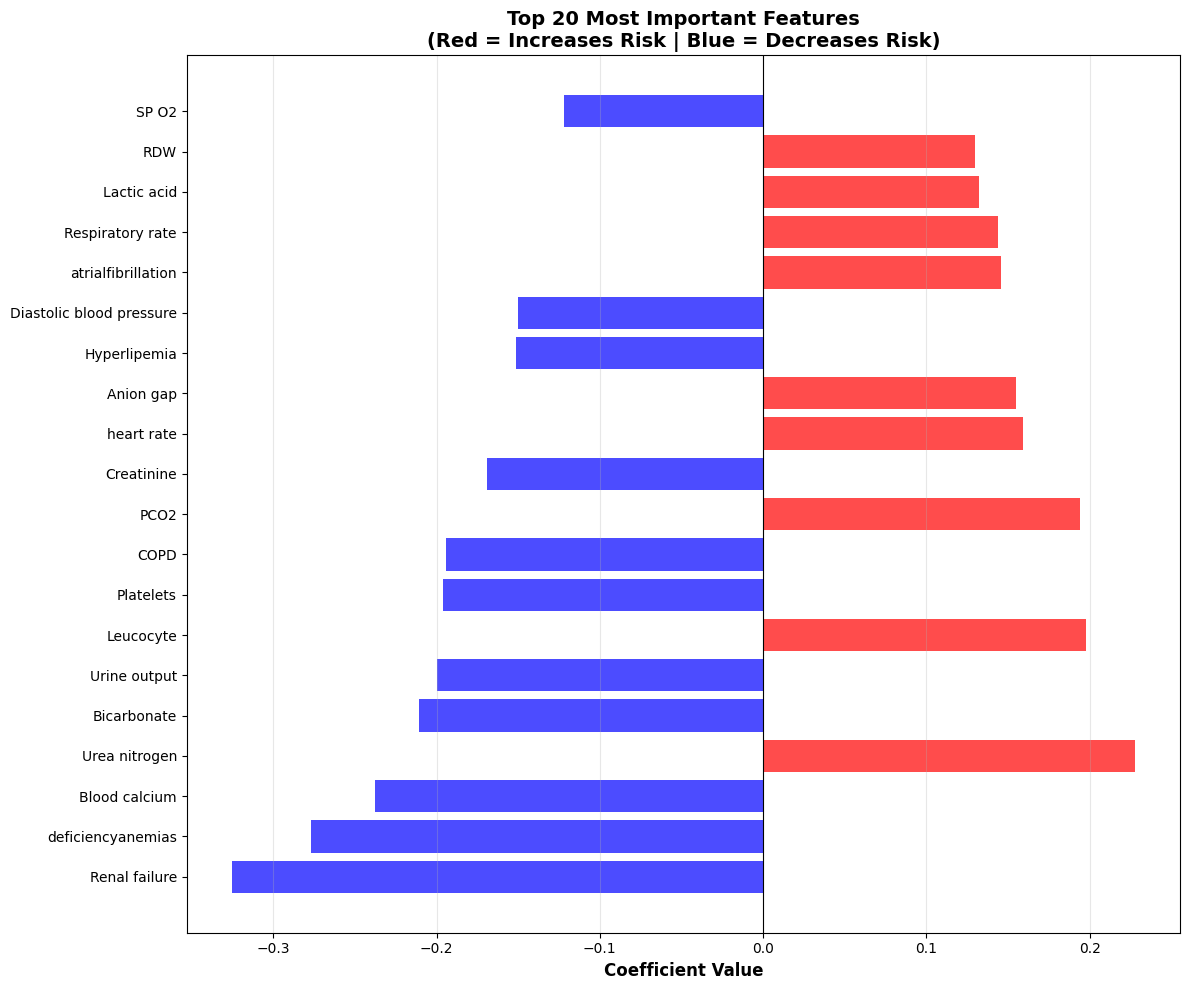


----------------------------------------------------------------------


In [45]:
print("-"*70)
print("FEATURE IMPORTANCE ANALYSIS")
print("-"*70)

# extract coefficients from the base estimator (before calibration)
base_lr = best_lr_pipeline.named_steps['clf']
coefficients = base_lr.coef_.ravel()
feature_names = X_train.columns

# create feature importance DataFrame
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients,
    'Abs_Coefficient': np.abs(coefficients)
}).sort_values('Abs_Coefficient', ascending=False)

# top 20 most important features
top_n = 20
top_features = feature_importance.head(top_n)

print(f"\nTop {top_n} Most Important Features:")
print("-"*70)
for idx, row in top_features.iterrows():
    direction = "↑ Increases" if row['Coefficient'] > 0 else "↓ Decreases"
    print(f"{row['Feature']:35s}  Coef: {row['Coefficient']:7.4f}  {direction} death risk")

# visualize top features
fig, ax = plt.subplots(figsize=(12, 10))

colors = ['red' if c > 0 else 'blue' for c in top_features['Coefficient']]
ax.barh(range(top_n), top_features['Coefficient'], color=colors, alpha=0.7)
ax.set_yticks(range(top_n))
ax.set_yticklabels(top_features['Feature'])
ax.set_xlabel('Coefficient Value', fontsize=12, fontweight='bold')
ax.set_title(f'Top {top_n} Most Important Features\n(Red = Increases Risk | Blue = Decreases Risk)', 
             fontsize=14, fontweight='bold')
ax.axvline(0, color='black', linestyle='-', linewidth=0.8)
ax.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

print("\n" + "-"*70)

In [46]:
""" data-driven selection of top features for Streamlit UI input
choose smallest K keeping PR-AUC and recall close to calibrated baseline """

# baseline from calibrated full-feature model
thresholds = np.linspace(0.1, 0.9, 41)
# re-optimize threshold on calibrated probs for fair baseline
best_f2_calib, best_thr_calib = -1, 0.5
for t in thresholds:
    y_hat_c = (y_prob_calib >= t).astype(int)
    f2_c = fbeta_score(y_test_array, y_hat_c, beta=2, pos_label=1, zero_division=0)
    if f2_c > best_f2_calib:
        best_f2_calib, best_thr_calib = f2_c, t

baseline_pr_auc = average_precision_score(y_test_array, y_prob_calib)
baseline_recall = recall_score(y_test_array, (y_prob_calib >= best_thr_calib).astype(int), pos_label=1)

print("\n" + "-"*70)
print("TOP FEATURES FOR STREAMLIT UI (Data-driven K)")
print("-"*70)
print(f"Baseline (calibrated) PR-AUC={baseline_pr_auc:.4f}, Recall@bestF2={baseline_recall:.4f}, thr={best_thr_calib:.2f}")

ks = [6, 8, 10, 12, 15]
rows = []

for k in ks:
    topk_feats = feature_importance.head(k)['Feature'].tolist()

    # refit SMOTE+LR with best params on top-k features
    pipe_k = Pipeline([
        ('smote', SMOTE(random_state=42,
                         k_neighbors=gs.best_params_.get('smote__k_neighbors', 5),
                         sampling_strategy=gs.best_params_.get('smote__sampling_strategy', 1.0))),
        ('clf', LogisticRegression(max_iter=2000,
                                   solver='liblinear',
                                   random_state=42,
                                   C=gs.best_params_['clf__C'],
                                   penalty=gs.best_params_['clf__penalty'],
                                   class_weight=gs.best_params_.get('clf__class_weight', None)))
    ])
    pipe_k.fit(X_train[topk_feats], y_train)

    # calibrate this reduced model as well
    calib_k = CalibratedClassifierCV(estimator=pipe_k, method='isotonic', cv=5)
    calib_k.fit(X_train[topk_feats], y_train)

    y_prob_k = calib_k.predict_proba(X_test[topk_feats])[:, 1]

    # optimize threshold by F2 for this subset
    best_f2_k, best_thr_k = -1, 0.5
    for t in thresholds:
        y_hat_k = (y_prob_k >= t).astype(int)
        f2_k = fbeta_score(y_test_array, y_hat_k, beta=2, pos_label=1, zero_division=0)
        if f2_k > best_f2_k:
            best_f2_k, best_thr_k = f2_k, t

    y_hat_k = (y_prob_k >= best_thr_k).astype(int)

    pr_auc_k = average_precision_score(y_test_array, y_prob_k)
    recall_k = recall_score(y_test_array, y_hat_k, pos_label=1)

    rows.append({
        'k': k,
        'pr_auc': pr_auc_k,
        'recall': recall_k,
        'f2': best_f2_k,
        'thr': best_thr_k,
        'pr_auc_drop': baseline_pr_auc - pr_auc_k,
        'recall_drop': baseline_recall - recall_k
    })
    print(f"k={k:2d} | PR-AUC: {pr_auc_k:.4f} | Recall: {recall_k:.4f} | F2: {best_f2_k:.4f} | thr={best_thr_k:.2f}")

k_df = pd.DataFrame(rows)

# select smallest k within tolerances (<=2% PR-AUC drop and <=3% recall drop)
tol_pr = 0.02 * baseline_pr_auc
tol_re = 0.03
candidates = k_df[(k_df['pr_auc_drop'] <= tol_pr) & (k_df['recall_drop'] <= tol_re)]
if len(candidates):
    top_k_ui = int(candidates.sort_values('k').iloc[0]['k'])
else:
    # fallback: minimize PR-AUC drop, then k
    top_k_ui = int(k_df.sort_values(['pr_auc_drop','k']).iloc[0]['k'])

# finalize feature list for UI
top_features_for_ui = feature_importance.head(top_k_ui)

print(f"\nSelected top_k_ui = {top_k_ui}")
print("\nThese features should be collected as user input in the web app:\n")
for idx, (i, row) in enumerate(top_features_for_ui.iterrows(), 1):
    print(f"{idx:2d}. {row['Feature']}")

ui_csv_path = '../data/processed/top_features_for_ui.csv'
top_features_for_ui[['Feature', 'Coefficient']].to_csv(ui_csv_path, index=False)
print(f"\nFeature list saved to '{ui_csv_path}' (top_k_ui={top_k_ui})")


----------------------------------------------------------------------
TOP FEATURES FOR STREAMLIT UI (Data-driven K)
----------------------------------------------------------------------
Baseline (calibrated) PR-AUC=0.4475, Recall@bestF2=0.7188, thr=0.12
k= 6 | PR-AUC: 0.4027 | Recall: 0.5625 | F2: 0.4545 | thr=0.10
k= 8 | PR-AUC: 0.4060 | Recall: 0.5312 | F2: 0.5030 | thr=0.18
k=10 | PR-AUC: 0.4154 | Recall: 0.5938 | F2: 0.4948 | thr=0.12
k=12 | PR-AUC: 0.4155 | Recall: 0.5625 | F2: 0.5389 | thr=0.22
k=15 | PR-AUC: 0.4063 | Recall: 0.6562 | F2: 0.5357 | thr=0.10

Selected top_k_ui = 12

These features should be collected as user input in the web app:

 1. Renal failure
 2. deficiencyanemias
 3. Blood calcium
 4. Urea nitrogen
 5. Bicarbonate
 6. Urine output
 7. Leucocyte
 8. Platelets
 9. COPD
10. PCO2
11. Creatinine
12. heart rate

Feature list saved to '../data/processed/top_features_for_ui.csv' (top_k_ui=12)


#### Model Saving for Deployment

Save the final calibrated model, optimal threshold, and metadata for Streamlit integration.

In [47]:
import joblib
import json

print("-"*70)
print("MODEL DEPLOYMENT PREPARATION")
print("-"*70)

os.makedirs('../models', exist_ok=True)

model_path = '../models/final_lr_model.pkl'
joblib.dump(final_model, model_path)
print(f"\nCalibrated model saved to: {model_path}")

metadata = {
    'model_type': 'Logistic Regression (Calibrated)',
    'optimal_threshold': float(optimal_threshold),
    'best_hyperparameters': gs.best_params_,
    'cv_metrics': {
        'pr_auc': float(gs.cv_results_['mean_test_ap'][gs.best_index_]),
        'recall': float(gs.cv_results_['mean_test_recall'][gs.best_index_]),
        'roc_auc': float(gs.cv_results_['mean_test_roc_auc'][gs.best_index_])
    },
    'test_metrics': {
        'pr_auc': float(average_precision_score(y_test_array, y_prob_calib)),
        'roc_auc': float(roc_auc_score(y_test_array, y_prob_calib)),
        'recall': float(recall_score(y_test_array, y_pred_calib, pos_label=1)),
        'precision': float(precision_score(y_test_array, y_pred_calib, pos_label=1)),
        'f2_score': float(fbeta_score(y_test_array, y_pred_calib, beta=2, pos_label=1))
    },
    'feature_names': list(X_train.columns),
    'top_15_features': list(top_features_for_ui['Feature'].values),
    'training_date': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S'),
    'random_seed': RANDOM_SEED
}

metadata_path = '../models/model_metadata.json'
with open(metadata_path, 'w') as f:
    json.dump(metadata, f, indent=2)
print(f"Model metadata saved to: {metadata_path}")

feature_info = {
    'all_features': list(X_train.columns),
    'n_features': len(X_train.columns),
    'top_15_features_for_ui': list(top_features_for_ui['Feature'].values)
}

feature_info_path = '../models/feature_info.json'
with open(feature_info_path, 'w') as f:
    json.dump(feature_info, f, indent=2)
print(f"Feature info saved to: {feature_info_path}")

print("\n" + "-"*70)
print("DEPLOYMENT PACKAGE READY")
print("-"*70)
print("\nFiles created:")
print(f"1. {model_path}")
print(f"2. {metadata_path}")
print(f"3. {feature_info_path}")
print(f"4. ../data/processed/top_features_for_ui.csv")

----------------------------------------------------------------------
MODEL DEPLOYMENT PREPARATION
----------------------------------------------------------------------

Calibrated model saved to: ../models/final_lr_model.pkl
Model metadata saved to: ../models/model_metadata.json
Feature info saved to: ../models/feature_info.json

----------------------------------------------------------------------
DEPLOYMENT PACKAGE READY
----------------------------------------------------------------------

Files created:
1. ../models/final_lr_model.pkl
2. ../models/model_metadata.json
3. ../models/feature_info.json
4. ../data/processed/top_features_for_ui.csv


In [48]:
print("\n" + "-"*70)
print("FINAL MODEL SUMMARY")
print("-"*70)

print("\n📊 Model Configuration:")
print(f"  - Algorithm: Logistic Regression (Calibrated with Isotonic)")
print(f"  - SMOTE Strategy: {gs.best_params_['smote__sampling_strategy']}")
print(f"  - Regularization (C): {gs.best_params_['clf__C']}")
print(f"  - Penalty: {gs.best_params_['clf__penalty']}")

print("\n📈 Performance Metrics (Test Set):")
print(f"  - PR-AUC:           {metadata['test_metrics']['pr_auc']:.4f}")
print(f"  - ROC-AUC:          {metadata['test_metrics']['roc_auc']:.4f}")
print(f"  - Recall (Died):    {metadata['test_metrics']['recall']:.4f}")
print(f"  - Precision (Died): {metadata['test_metrics']['precision']:.4f}")
print(f"  - F2-Score:         {metadata['test_metrics']['f2_score']:.4f}")

print("\n🎯 Decision Threshold:")
print(f"  - Optimal: {optimal_threshold:.3f} (maximizes F2-score)")

print("\n🔑 Top 5 Features:")
for i, feat in enumerate(top_features_for_ui['Feature'].head(5), 1):
    coef = top_features_for_ui[top_features_for_ui['Feature'] == feat]['Coefficient'].values[0]
    direction = "↑" if coef > 0 else "↓"
    print(f"  {i}. {feat} ({direction})")

print("\n" + "-"*70)
print("Model training and deployment preparation complete!")
print("-"*70)


----------------------------------------------------------------------
FINAL MODEL SUMMARY
----------------------------------------------------------------------

📊 Model Configuration:
  - Algorithm: Logistic Regression (Calibrated with Isotonic)
  - SMOTE Strategy: 0.7
  - Regularization (C): 0.01
  - Penalty: l2

📈 Performance Metrics (Test Set):
  - PR-AUC:           0.4475
  - ROC-AUC:          0.8001
  - Recall (Died):    0.3438
  - Precision (Died): 0.6875
  - F2-Score:         0.3819

🎯 Decision Threshold:
  - Optimal: 0.460 (maximizes F2-score)

🔑 Top 5 Features:
  1. Renal failure (↓)
  2. deficiencyanemias (↓)
  3. Blood calcium (↓)
  4. Urea nitrogen (↑)
  5. Bicarbonate (↓)

----------------------------------------------------------------------
Model training and deployment preparation complete!
----------------------------------------------------------------------
